# Bayesian AB Testing 

## Scenario: Email-to-success

Going through the scenario of email-to-success based on a different UI element.

We are going to do the following steps: 

1. setup Priors 
2. Bayes' Theorem updates priors with observed data = posterior
3. Calculate credible intervals 
4. Calculate Bayesian stats 

### Control and Treatment Groups 

A user receives exactly 1 email and a very small percent of those instances result in the successful submission of a form (*success event*). The users are split into two equal groups, 50% as control (**A**) and 50% as treatment (**B**). They get the same exact emails and have the same exact form to fill out. There is only one difference between the two groups that has to do with UI layouts *(e.g. submit button on the left vs the right of the screen)*. Historically, all of the emails in the past have used the **A** UI layout. Now we have an equal split in users that have gotten **A** email and **B** email.

We are going to call the number of users that successfully submit the final form, **A_success** and **B_success**. See the setup of the data below. 

### Overview of data

```python
    number_of_emails = 150000
    A_success = 450
    B_success = 600 
```

Just to reiterate, the above means *450 of the 150,000* emails were successful in **group A**. On the other hand, *600 of the 150,000* emails were successful in **group B**. 

## Statistics to Calculate

**Three** Bayesian statistics to calculate when performing AB testing: 

A. Treatment Lift

B. Probability of being the best

C. Expected Loss

### A. Treatment Lift 

The percent change between treatment and control groups. 

```python
    lift = (treatment - control) / control 
```

With our numbers: 


In [78]:
# Number of Emails 
n_ = 150000

# A_success 
A_s = 600
# B_success
B_s = 450 

lift = (A_s - B_s) / B_s
print(f"\nTreatment Lift: {lift:.3f}\n") 


Treatment Lift: 0.333



### Binary Data 

Conversion data, *e.g. successful form or not*, is a scenario where a binomial distrubtion describes the data. The conjugate prior of the binomial is the beta distribution.

### B. Probability of being the best 

For each of our 10,000 samples (runs) of our Monte Carlo simulation, we calculate the percent of time that B outperforms A. 

```python
    # Assume we have a sampling function and have our A and B distributions
    A_samples = sample_from_distribution(A_distribution, n = 10000)  
    B_samples = sample_from_distribution(B_distribution, n = 10000)
    
    # Probability of being the best 
    p_best = mean(int(B_samples > A_samples))
```

### C. Expected Loss 

In other words, the cost of implementing an incorrect treatment. Calculated by finding the max of **(B - A)** and **0 for every sample**. Thus, we get 10,000 of those numbers since we are sampling 10,000 times. We then take the mean of those 10,000 values. 

```python
    e_loss = mean(max(B_samples - A_samples, 0))
```

# Overview of Steps 

## Step 1: Priors 

Let's use Beta(1, 1), uniform random distribution. 

## Step 2: Data 

Use your actual data to update priors with Bayes theorem to get posteriors.

## Step 3: Posteriors 

control = Beta(1 + 450, 1 + 150,000 - 450) 

treatment = Beta(1 + 600, 1 + 150,000 - 600) 

## Step 4: Sample 

Monte Carlo *(simple, Markov Chain, or other Bayesian engines)* is a bunch of independent runs of **steps 1 - 3**. So, above we mention using 10,000 samples. That means we generate 10,000 indepedent **1.** Beta(1, 1) prior distributions, **2.** run through Bayes theorem, and **3.** get posterior distributions as updated Betas -> Beta(1 + 450, 1 + 150,000 - 450) and Beta(1 + 600, 1 + 150,000 - 600).

As you can tell, this means each of these 10,000 runs are indepdent and can be ran in parallel. This allows Bayesian statistics (*which are known to be more computationally expensive than frequentist approaches*) to scale very efficiently since the programs can be parallelized. 
 

# Full Working Code 

**Note: uncomment and install following**

In [1]:
#%pip install pymc3

/Users/macbookair/miniconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [treatment_theta, control_theta]


/Users/macbookair/miniconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/macbookair/miniconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


                  mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
control_theta    0.003  0.0   0.003    0.003        0.0      0.0   17321.0  \
treatment_theta  0.004  0.0   0.004    0.004        0.0      0.0   18645.0   
delta            0.001  0.0   0.001    0.001        0.0      0.0   17934.0   

                 ess_tail  r_hat  
control_theta     13681.0    1.0  
treatment_theta   14102.0    1.0  
delta             12868.0    1.0  


/Users/macbookair/miniconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Probability that treatment is better than control: 100.00%


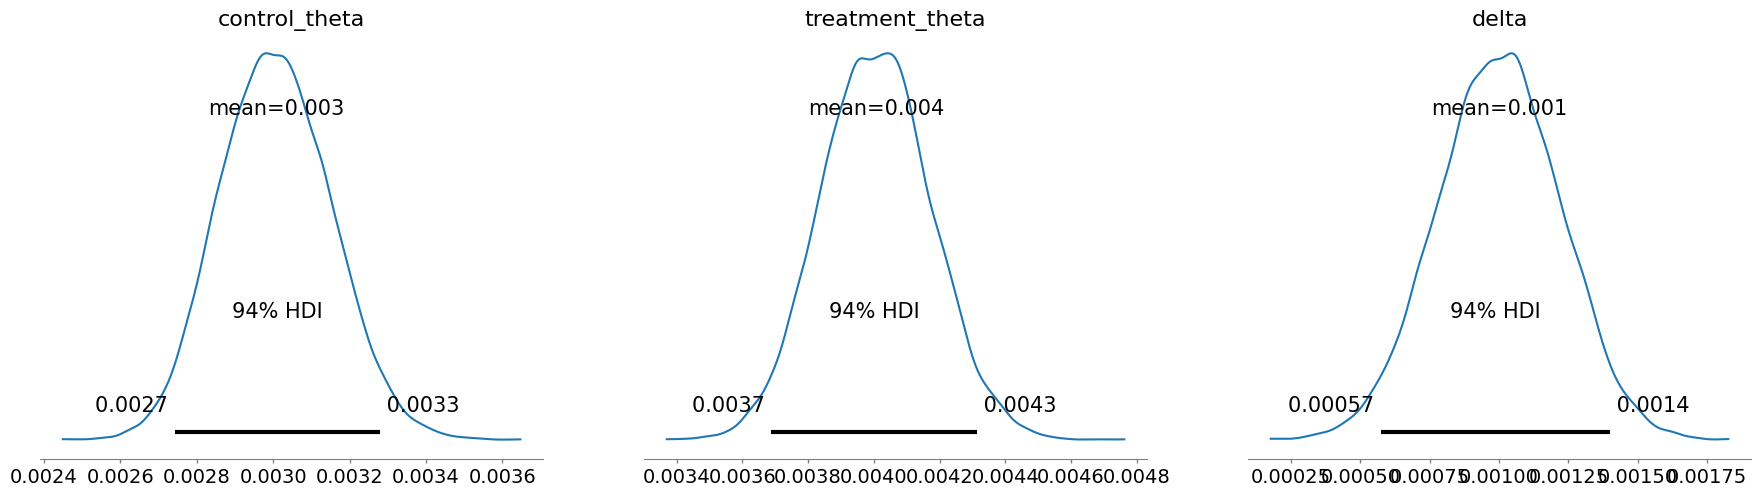

In [2]:
import pymc3 as pm
import numpy as np

# Observed data
control_successes = 450
control_trials = 150000
treatment_successes = 600
treatment_trials = 150000

# Prior parameters
alpha_prior = 1
beta_prior = 1

# Define the Bayesian model
with pm.Model() as ab_model:
    # Prior distributions for control and treatment groups
    control_theta = pm.Beta('control_theta', alpha=alpha_prior, beta=beta_prior)
    treatment_theta = pm.Beta('treatment_theta', alpha=alpha_prior, beta=beta_prior)
    
    # Likelihood of observed data
    control_obs = pm.Binomial('control_obs', n=control_trials, p=control_theta, observed=control_successes)
    treatment_obs = pm.Binomial('treatment_obs', n=treatment_trials, p=treatment_theta, observed=treatment_successes)
    
    # Calculate the difference in means
    delta = pm.Deterministic('delta', treatment_theta - control_theta)

# Perform Bayesian inference
with ab_model:
    trace = pm.sample(draws=10000, tune=2000, target_accept=0.9, cores=1)

# Print summary statistics of the posterior distribution
print(pm.summary(trace, var_names=['control_theta', 'treatment_theta', 'delta']))

# Plot posterior distributions
pm.plot_posterior(trace, var_names=['control_theta', 'treatment_theta', 'delta'])

# Calculate the probability that treatment is better than control
prob_treatment_better = np.mean(trace['delta'] > 0)
print(f"Probability that treatment is better than control: {prob_treatment_better:.2%}")